# Quora question pairs: training

## Import packages

In [31]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

## Initialize global variables

In [56]:
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32

## Load the dataset, embedding matrix 

In [49]:
q1_data = np.load(open('q1_train.npy', 'rb'))
q2_data = np.load(open('q2_train.npy', 'rb'))
labels = np.load(open('label_train.npy', 'rb'))
word_embedding_matrix = np.load(open('word_embedding_matrix.npy', 'rb'))
with open('nb_words.json', 'r') as f:
    nb_words = json.load(f)['nb_words']

In [52]:
word_embedding_matrix.shape[0]

96493

## Partition the dataset into train and test sets

In [34]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

## Define the model

In [53]:
question1 = Input(shape=(25,))
question2 = Input(shape=(25,))

#create embedding using pre-trained GLOVE vectors

embedding_layer = Embedding(word_embedding_matrix.shape[0],
                            EMBEDDING_DIM,
                            weights=[word_embedding_matrix],
                            input_length=25,
                            trainable=False)

#create time distributed embedding for question 1 and question 2
embedded_sequences_1 = embedding_layer(question1)
time_distributed_1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_1)
q1_time_dist = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(time_distributed_1)


embedded_sequences_2 = embedding_layer(question2)
time_distributed_2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_2)
q2_time_dist = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(time_distributed_2)

#Concatenate the representations for question 1 and 2
concatenated = concatenate([q1_time_dist,q2_time_dist])

#dense layer 1
merged = Dense(200, activation='relu')(concatenated)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 2
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 3
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 4
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#final prediction using sigmoid activation
final_label = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=final_label)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 25, 300)      28947900    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 25, 300)      28947900    input_4[0][0]                    
__________________________________________________________________________________________________
time_distr

## Train the model, checkpointing weights with best validation accuracy

In [38]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()

#callback to store the best weights
callbacks = [ModelCheckpoint('question_pairs_weights_network1.h5', monitor='val_acc', save_best_only=True)]

history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=0.2,
                    verbose=2,
                    batch_size=32,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Train on 258743 samples, validate on 64686 samples
Epoch 1/25
 - 234s - loss: 0.5399 - acc: 0.7261 - val_loss: 0.5342 - val_acc: 0.7380
Epoch 2/25
 - 231s - loss: 0.4956 - acc: 0.7573 - val_loss: 0.4781 - val_acc: 0.7679
Epoch 3/25
 - 235s - loss: 0.4720 - acc: 0.7720 - val_loss: 0.4681 - val_acc: 0.7707
Epoch 4/25
 - 233s - loss: 0.4484 - acc: 0.7865 - val_loss: 0.4577 - val_acc: 0.7781
Epoch 5/25
 - 229s - loss: 0.4295 - acc: 0.7985 - val_loss: 0.4496 - val_acc: 0.7888
Epoch 6/25
 - 236s - loss: 0.4133 - acc: 0.8079 - val_loss: 0.4372 - val_acc: 0.7905
Epoch 7/25
 - 235s - loss: 0.3954 - acc: 0.8182 - val_loss: 0.4316 - val_acc: 0.7947
Epoch 8/25
 - 233s - loss: 0.3803 - acc: 0.8276 - val_loss: 0.4355 - val_acc: 0.7940
Epoch 9/25
 - 231s - loss: 0.3718 - acc: 0.8318 - val_loss: 0.4799 - val_acc: 0.7608
Epoch 10/25
 - 227s - loss: 0.3573 - acc: 0.8401 - val_loss: 0.4249 - val_acc: 0.7985
Epoch 11/25
 - 240s - loss: 0.3457 - acc: 0.8464 - val_loss: 0.4230 - val_acc: 0.8014
Epoch 12/25


## Plot training and validation accuracy

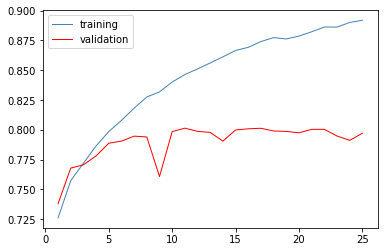

In [39]:
import matplotlib.pyplot as plt
# Data
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21) })
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']}) 
# multiple line plot
ax= plt.plot( 'epoch', 'training', data=acc,markersize=12, color='steelblue', linewidth=1)
ax= plt.plot( 'epoch', 'validation', data=acc,markersize=12, color='red', linewidth=1)

plt.legend()

In [40]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 11 = 0.8014


## Evaluate the model on the test partition

In [41]:
model.load_weights(model_weights)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.4243, accuracy = 0.7998


## Calculating AUC-ROC

In [42]:
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
pred_label = model.predict([Q1_test, Q2_test], verbose=0)


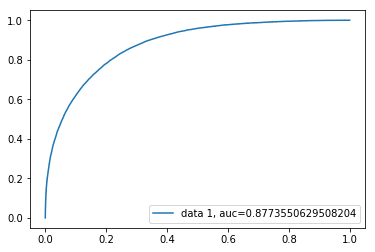

AUC score is =  0.8773550629508204


In [43]:

fpr, tpr, _ = roc_curve(y_test,  pred_label)
auc = roc_auc_score(y_test, pred_label)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC score is = ', auc)

## Testing individual sentences

### Use this section as a server for the Web Application

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import json
from keras.models import Model
from keras.layers import Input, TimeDistributed, dot, Dense, Lambda, Flatten, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import pickle

Using TensorFlow backend.


In [2]:
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32

with open('nb_words.json', 'r') as f:
    nb_words = json.load(f)['nb_words']
    
word_embedding_matrix = np.load(open('word_embedding_matrix.npy', 'rb'))

with open('word_index.pickle', 'rb') as handle:
    word_indices = pickle.load(handle)

In [57]:
question1 = Input(shape=(25,))
question2 = Input(shape=(25,))

#create embedding using pre-trained GLOVE vectors

embedding_layer = Embedding(word_embedding_matrix.shape[0],
                            EMBEDDING_DIM,
                            weights=[word_embedding_matrix],
                            input_length=25,
                            trainable=False)

#create time distributed embedding for question 1 and question 2
embedded_sequences_1 = embedding_layer(question1)
time_distributed_1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_1)
q1_time_dist = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(time_distributed_1)


embedded_sequences_2 = embedding_layer(question2)
time_distributed_2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_2)
q2_time_dist = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(time_distributed_2)

#Concatenate the representations for question 1 and 2
concatenated = concatenate([q1_time_dist,q2_time_dist])

#dense layer 1
merged = Dense(200, activation='relu')(concatenated)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 2
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 3
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 4
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#final prediction using sigmoid activation
final_label = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=final_label)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.load_weights('question_pairs_weights_network1.h5')
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.2763, accuracy = 0.8881


In [5]:
def word2vec(question):
    word_seq = keras.preprocessing.text.text_to_word_sequence(question)
    
    vec_sequence = [word_indices[w] for w in word_seq]
    
    vec_sequence = pad_sequences([vec_sequence], maxlen= 25)
    return vec_sequence
 

In [15]:
word2vec(question1)

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 3840,    1, 3016,
        1244,    3, 4481]])

In [58]:
question1 = 'How are the two wheeler insurance from Bharti Axa insurance?'
question2 = 'Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?'

model.load_weights(model_weights)
predictions = model.predict([word2vec(question1), word2vec(question2)], verbose=0)

predictions

array([[1.26313635e-05]], dtype=float32)

In [44]:
names = np.append(train['question1'],train['question2'])

In [56]:
len(q1_data)

404287

In [57]:
len(names)

808580

In [81]:
question1 = 'Which food not emulsifiers?'
for i in range(len(q1_data)):
    if model.predict([word2vec(question1), np.array([q1_data[i]])], verbose=0)>0.95:
        print(model.predict([word2vec(question1), np.array([q1_data[i]])], verbose=0))
        print(names[i])

[[0.965684]]
Which is best mobile under 15000?
[[0.9717353]]
Have the Ancient Mayans been scientifically tested?
[[0.9717353]]
Have the Ancient Mayans been scientifically tested?
[[0.97535783]]
Is modi government doing anything to remove caste based reservation?
[[1.]]
Are leopons real?
[[0.9519369]]
How can Modi government prevent black money by discontinuing 500 and 1000 notes?
[[0.9634354]]
How can black money brought out by discontinuing 500 and 1000 notes?
[[0.9634354]]
How can black money brought out by discontinuing 500 and 1000 notes?
[[0.95183605]]
How can we remove reservation from the Indian constitution?
[[0.96757495]]
How do I know who viewed my WhatsApp display pic?
[[0.9717353]]
Have the Ancient Mayans been scientifically tested?
[[0.9504208]]
What are the best smartphones under 15000?
[[0.9751672]]
Have the Ancient Anasazi been scientifically tested?
[[0.9578092]]
What is an isotonic solution? What are some examples?
[[0.9751672]]
Have the Ancient Anasazi been scientifi

[[0.98209]]
How company's divides shares between NSe and BSE?
[[0.96572924]]
What upgrades are expected with the next MacBook Pro with retina display and is there a firm release date?
[[0.95762736]]
Which is a good solar panel installation provider in Long Beach, California CA?
[[1.]]
What are some clever company names?
[[0.95762736]]
What are the flaws in Indian Education system?
[[0.95506334]]
What is the contribution of agriculture in India's national income in 2014-15?
[[0.9717353]]
What are the meanings of the following sentences from Moby Dick? (see details)
[[0.96757495]]
What does it mean if A guy text you a casual conversation in a week after he said he wanted to be just friends on the last date?
[[0.9519369]]
How can we find professors, PhD & masters students from universities of Brazil who would like to share their knowledge for free to record MOOCs?
[[0.98159385]]
Where does the large amount of energy in a fusion or fission reaction come from?
[[0.9751672]]
How does one bec

In [29]:
test = pd.read_csv('test1.csv')
test_q1 = test['question1'][:2]
test_q2 = test['question2'][:2]


0    How does the Surface Pro himself 4 compare wit...
1    Should I have a hair transplant at age 24? How...
Name: question1, dtype: object

In [79]:
model.predict([word2vec('Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?'),word2vec('Im a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?')])

array([[0.590352]], dtype=float32)

In [ ]:
for i in range(len(Q1_train)):
    if model.predict([word2vec(test_q2[1]), np.array([Q1_train[i]])], verbose=0)>0.95:
        print(names[i])